# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.constants import c, elementary_charge
import pandas as pd
import pickle as pkl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [12,8] # bigger figures

In [3]:
# import package
# installed via pip
from emtracks.particle import trajectory_solver # main solver object
from emtracks.conversions import one_gev_c2_to_kg # conversion for q factor (transverse momentum estimate)
from emtracks.tools import *#InitConds # initial conditions namedtuple
from emtracks.mapinterp import get_df_interp_func  # factory function for creating Mu2e DS interpolation function
from emtracks.Bdist import get_B_df_distorted

ERROR! Please set $EMTRACKS_DDIR and $EMTRACKS_PDIR. Setting defaults (current directory)


In [4]:
datadir = "/home/shared_data/"
plotdir = datadir+"plots/randomphi/"
mapdir = datadir+"Bmaps/"

### Define Distorted B Field

In [5]:
B_Mu2e_func = get_df_interp_func(mapdir+"Mu2e_DSMap_V13.p", gauss=False)
df_Mu2e = pd.read_pickle(mapdir+"Mu2e_DSMap_V13.p")
start_point = 3
end_point = 14
initial_B = 4.5 #(rougly 1% distortion at z = 3.0, 0% at z = 14)
final_B = 0
df_Mu2e_dis = get_B_df_distorted(df_Mu2e, v="0", Bz0 = initial_B, Bzf = 0, z0 = start_point, zf = end_point) 
B_Mu2e_dis = get_df_interp_func(df=df_Mu2e_dis, gauss=False)

Text(0, 0.5, 'B (gauss)')

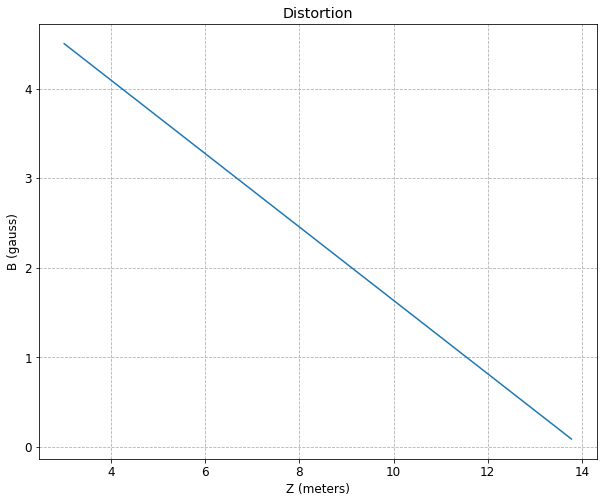

In [6]:
m = (final_B - initial_B) / (end_point - start_point)
n = 50
n1 = (end_point - start_point) / n
t = np.arange(start_point, end_point, n1)
x = plt.plot(t, ((t - start_point)*m) + initial_B)
plt.title("Distortion")
plt.xlabel("Z (meters)")
plt.ylabel("B (gauss)")

# Functions

In [7]:
def get_random_phi(N):   #change left boundary to math.pi work with those values later - if it works in some cases, stick with the stuff that works then go back
    # calls np.random, returns np.array with N randomized phi values
    phis = np.random.uniform(0, 2*math.pi, N) # uniform distribution between 0 and 2pi
    return phis

In [8]:
def run_solver(phi, N_calc, field, xnaught, ynaught, znaught):
    ic_Mu2e = InitConds(t0=0., tf=4e-8, N_t=N_calc,
                    x0=xnaught, y0=ynaught, z0=znaught,
                    p0=104.96, theta0=np.pi/3, phi0=phi)
    e_solver = trajectory_solver(ic_Mu2e, B_func=field, bounds=bounds_Mu2e)
    sol = e_solver.solve_trajectory(verbose = False, atol=1e-8, rtol=1e-8) # high tolerance so it runs quickly for testing
    df = e_solver.dataframe
    df['r'] = ((df['x']-xnaught)**2 + (df['y']-ynaught)**2)**(1/2)
    return df

In [9]:
def find_track_at_z(df, z): 
    delta = 10/4001   #approximate z range divided by number of points
    mask = (df.z < z + delta) & (df.z > z - delta)
    
    while (len(df.z[mask]) > 2):
        delta = delta / 2
        mask = (df.z < z + delta) & (df.z > z - delta)
    while (len(df.z[mask]) == 0):
        delta = delta*4
        mask = (df.z < z + delta) & (df.z > z - delta)
       
    df2 = df.loc[mask]
    df2 = df2.apply(pd.to_numeric)
    return (df2.iloc[0]['x'], df2.iloc[0]['y'], df2.iloc[0]['z'], df2.iloc[0]['t'], df2.iloc[0]['r'])

In [10]:
def plot_impact_at_calorimeter(ts, phis, rs, xs, ys, zs, output_directory):
    
    fig = plt.figure()
    plt.scatter(xs, ys, c = phis)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Y as a fn of X")
    max_coord = 1.25*np.max(abs(np.array([xs,ys])))
    plt.xlim(-max_coord, max_coord)
    plt.ylim(-max_coord, max_coord)
    fig.savefig(plotdir+output_directory+"Scatter_y_vs_x.pdf")
    fig.savefig(plotdir+output_directory+"Scatter_y_vs_x.png")
    
    fig2 = plt.figure()
    plt.scatter(phis, xs)
    plt.xlabel("phi_values (rad)")
    plt.ylabel("x coordinate")
    plt.title("X as a fn of phi")
    #plt.xlim(-6, 6)
    #plt.ylim(-2, 2)
    fig2.savefig(plotdir+output_directory+"Scatter_x_vs_phi.pdf")
    fig2.savefig(plotdir+output_directory+"Scatter_x_vs_phi.png")
    
    fig3 = plt.figure()
    plt.scatter(phis, ys)
    plt.xlabel("phi_values (rad)")
    plt.ylabel("y coordinate")
    plt.title("Y as a fn of phi")
    #plt.xlim(-6, 6)
    #plt.ylim(-2, 2)
    fig3.savefig(plotdir+output_directory+"Scatter_y_vs_phi.pdf")
    fig3.savefig(plotdir+output_directory+"Scatter_y_vs_phi.png")

    fig4 = plt.figure()
    x = xs
    num_bins = 50
    n, bins, patches = plt.hist(x, num_bins, facecolor='blue')
    plt.xlabel('xcoord')
    plt.ylabel('number of occurences')
    plt.title('Histogram of x-coord')
    fig4.savefig(plotdir+output_directory+"Histogram_x.pdf")
    fig4.savefig(plotdir+output_directory+"Histogram_x.png")
    
    fig5 = plt.figure()
    y = ys
    num_bins = 50
    n, bins, patches = plt.hist(y, num_bins, facecolor='blue')
    plt.xlabel('ycoord')
    plt.ylabel('number of occurences')
    plt.title('Histogram of y-coord')
    fig5.savefig(plotdir+output_directory+"Histogram_y.pdf")
    fig5.savefig(plotdir+output_directory+"Histogram_y.png")
    
    fig6 = plt.figure()
    r = rs
    num_bins = 50
    n, bins, patches = plt.hist(r, num_bins, facecolor='blue')
    plt.xlabel('radius')
    plt.ylabel('number of occurences')
    plt.title('Histogram of R')
    fig6.savefig(plotdir+output_directory+"Histogram_R.pdf")
    fig6.savefig(plotdir+output_directory+"Histogram_R.png")
    
    actualrad = ((((max(xs) - min(xs)) / 2) + ((max(ys) - min(ys)) / 2)) / 2)
    print ('actual radius: ' + str(actualrad))

In [11]:
def plotjoint(x, y, output_directory):
    x1, x2 = x[2], y[2]
    num_bins = 20

    m1 = np.mean(x1)
    std1 = np.std(x1)
    m2 = np.mean(x2)
    std2 = np.std(x2)

    fig1 = plt.figure()

    plt.hist(x1, alpha = 0.3, bins = num_bins, facecolor='blue', label = 'Mu2e Field')
    plt.hist(x2, alpha = 0.8, bins = num_bins, facecolor='orange', label = 'Graded Field')

    plt.legend()
    plt.legend()

    plt.text(0.3, 21, '\u03BC = '+str(round(np.mean(x1), 5)), fontsize = 8)
    plt.text(0.3, 20.6, '\u03C3 = '+str(round(np.std(x1), 5)), fontsize = 8)
    plt.text(0.3, 20.2, '\u03BC graded = '+str(round(np.mean(x2), 5)), fontsize = 8)
    plt.text(0.3, 19.8, '\u03C3 graded = '+str(round(np.std(x2), 5)), fontsize = 8)

    plt.xlabel('Radius (meters)')
    plt.ylabel('Occurences')
    plt.title('Histogram of Radius At Z=13 Meters')  
    fig1.show
    fig1.savefig(plotdir+output_directory+"Graded_radiushist.pdf")
    fig1.savefig(plotdir+output_directory+"Graded_radiushist.pdf")

    #---------------
    x1, x2 = x[3], y[3]
    num_bins = 20
    m1 = np.mean(x1)
    std1 = np.std(x1)
    m2 = np.mean(x2)
    std2 = np.std(x2)

    fig2 = plt.figure()

    plt.hist(x1, alpha = 0.3, bins = num_bins, facecolor='blue',  label = 'normal')
    plt.hist(x2, alpha = 0.8, bins = num_bins, facecolor='orange',  label = 'graded')

    plt.legend()

    plt.text(0.2, 17, '\u03BC = '+str(round(np.mean(x1), 5)), fontsize = 8)
    plt.text(0.2, 16.5, '\u03C3 = '+str(round(np.std(x1), 5)), fontsize = 8)
    plt.text(0.2, 16, '\u03BC graded = '+str(round(np.mean(x2), 5)), fontsize = 8)
    plt.text(0.2, 15.5, '\u03C3 graded = '+str(round(np.std(x2), 5)), fontsize = 8)

    plt.xlabel('X (meters)')
    plt.ylabel('Occurences')
    plt.title('Histogram of X')  
    fig2.show
    fig2.savefig(plotdir+output_directory+"Graded_xhist.pdf")
    fig2.savefig(plotdir+output_directory+"Graded_xhist.pdf")


    #-----

    x1, x2 = x[4], y[4]
    num_bins = 20
    m1 = np.mean(x1)
    std1 = np.std(x1)
    m2 = np.mean(x2)
    std2 = np.std(x2)

    fig3 = plt.figure()

    plt.hist(x1, alpha = 0.3, bins = num_bins, facecolor='blue',  label = 'normal')
    plt.hist(x2, alpha = 0.8, bins = num_bins, facecolor='orange',  label = 'graded')

    plt.legend()

    plt.text(0.2, 16.5, '\u03BC = '+str(round(np.mean(x1), 5)), fontsize = 8)
    plt.text(0.2, 16, '\u03C3 = '+str(round(np.std(x1), 5)), fontsize = 8)
    plt.text(0.2, 15.5, '\u03BC graded = '+str(round(np.mean(x2), 5)), fontsize = 8)
    plt.text(0.2, 15, '\u03C3 graded = '+str(round(np.std(x2), 5)), fontsize = 8)

    plt.xlabel('Y (meters)')
    plt.ylabel('Occurences')
    plt.title('Histogram of X')  
    fig3.show
    fig3.savefig(plotdir+output_directory+"Graded_yhist.pdf")
    fig3.savefig(plotdir+output_directory+"Graded_yhist.pdf")
    

## First Run Function (No Graded Field)

In [12]:
def run(N, output_directory):
    phis = get_random_phi(N)
    ts = []
    xs = []
    ys = []
    zs = []
    rs = []
    # for each phi, run create solver object and save trajectory object
    for phi in phis:
        dataframe = run_solver(phi, 4001, B_Mu2e_func, 0.054094482, 0.03873037, 5.988900879) #second argument is how many steps in numerical integration
        x, y, z, t, r = find_track_at_z(dataframe,13)
        ts.append(t)
        xs.append(x)
        ys.append(y)
        zs.append(z)
        rs.append(r)
    # convert everything to numpy arrays
    ts = np.array(ts)
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    rs = np.array(rs)
    # plot results (and save plots)
    plot_impact_at_calorimeter(ts, phis, rs, xs, ys, zs, output_directory)
    return (ts, phis, rs, xs, ys, zs)

actual radius: 0.37420480602317174


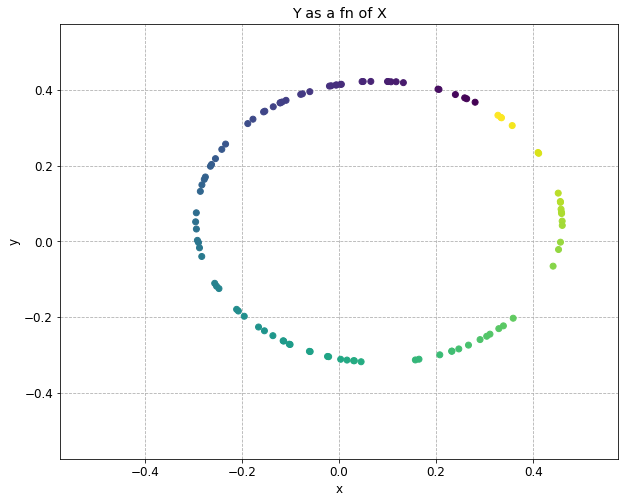

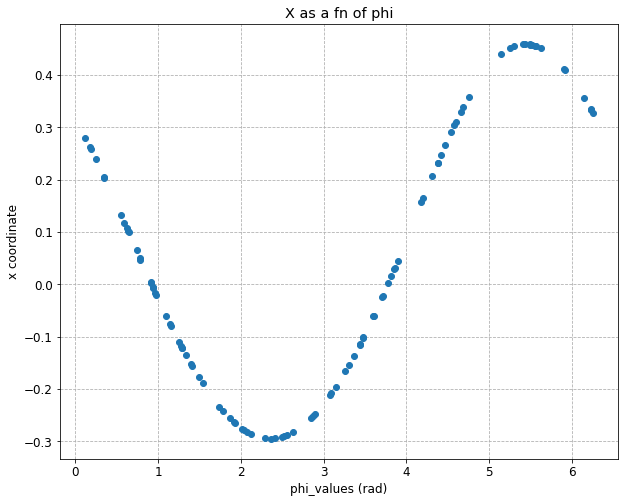

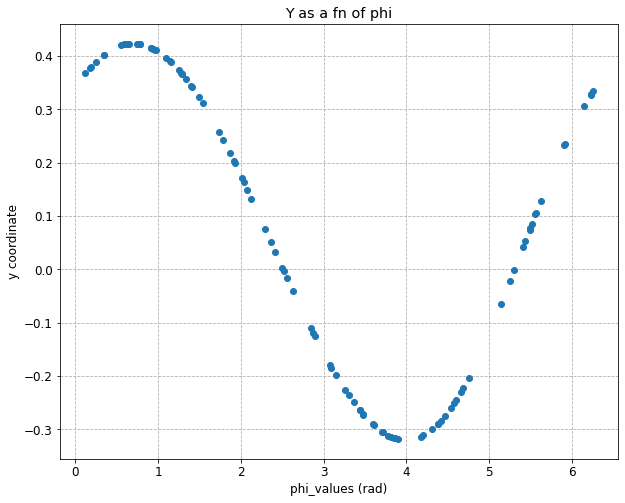

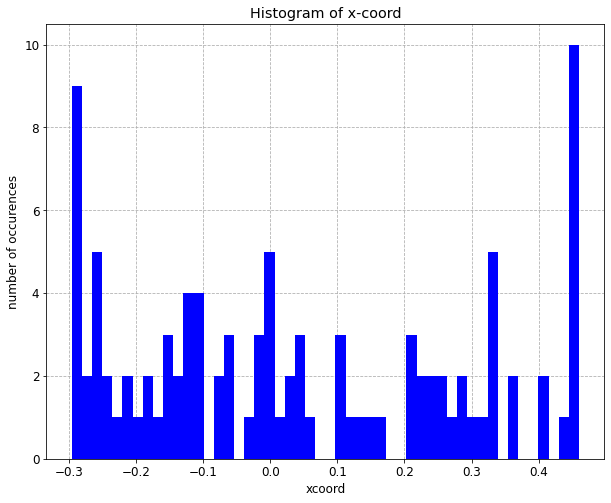

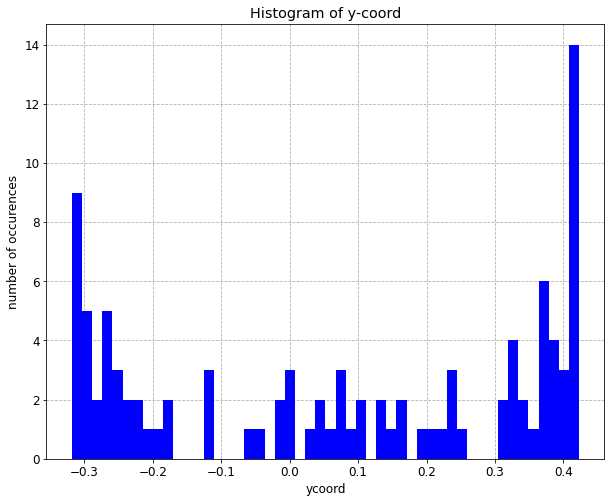

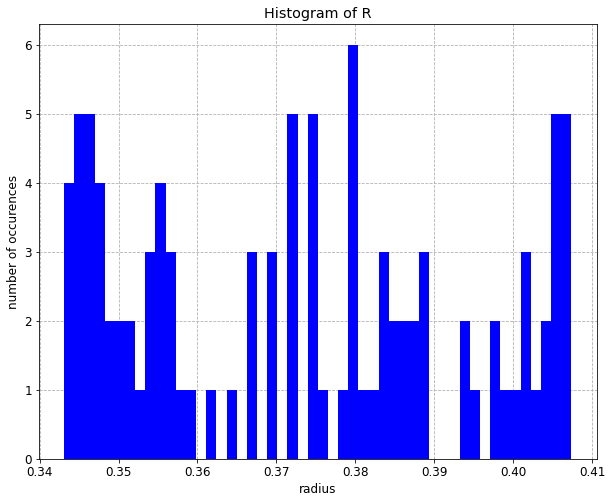

In [16]:
x = run(100, "run1/")
#np.save(x)

## Second Run Function (Graded Field)

In [17]:
def run2(N, output_directory):
    phis = get_random_phi(N)
    ts = []
    xs = []
    ys = []
    zs = []
    rs = []
    # for each phi, run create solver object and save trajectory object
    for phi in phis:
        dataframe = run_solver(phi, 4001, B_Mu2e_dis, 0.054094482, 0.03873037, 5.988900879) #second argument is how many steps in numerical integration
        x, y, z, t, r = find_track_at_z(dataframe,13)
        ts.append(t)
        xs.append(x)
        ys.append(y)
        zs.append(z)
        rs.append(r)
    # convert everything to numpy arrays
    ts = np.array(ts)
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    rs = np.array(rs)
    # plot results (and save plots)
    plot_impact_at_calorimeter(ts, phis, rs, xs, ys, zs, output_directory)
    return (ts, phis, rs, xs, ys, zs)
    

actual radius: 0.37592263309783025


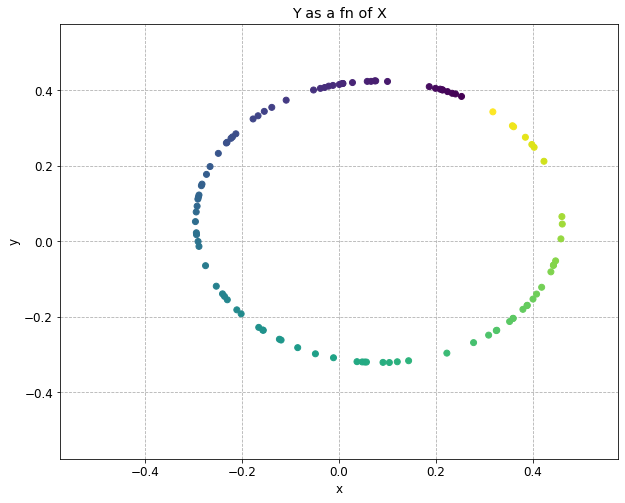

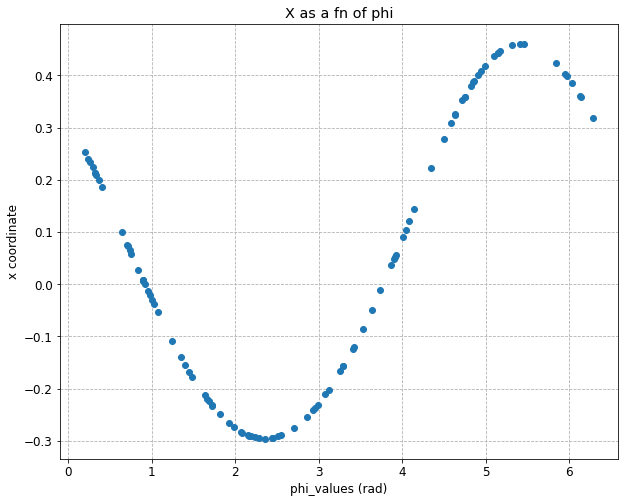

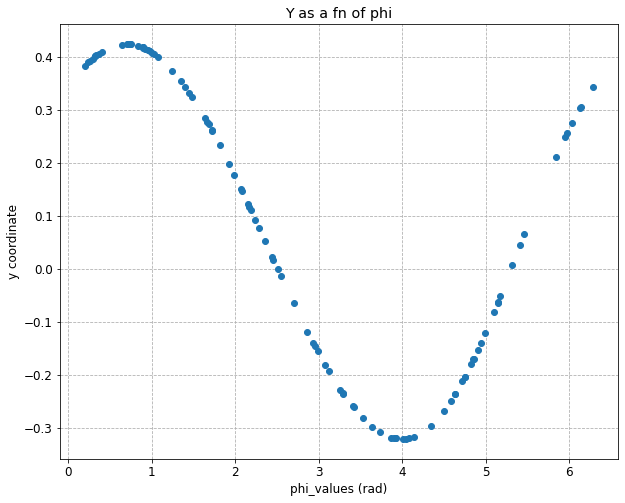

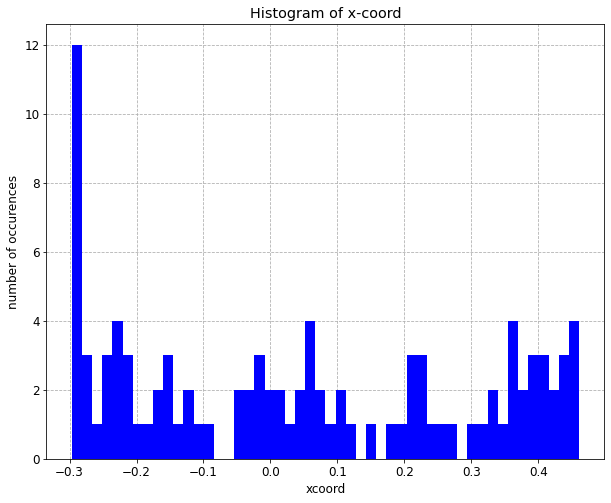

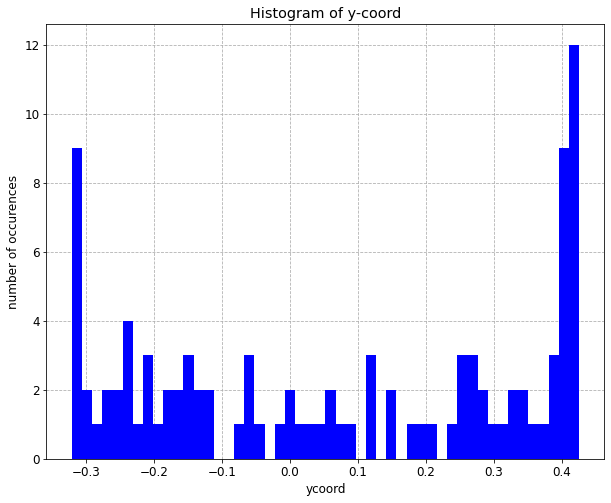

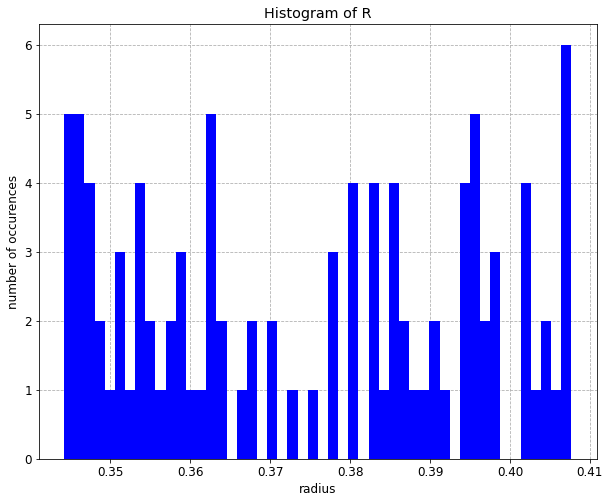

In [18]:
y = run2(100, 'run2/')

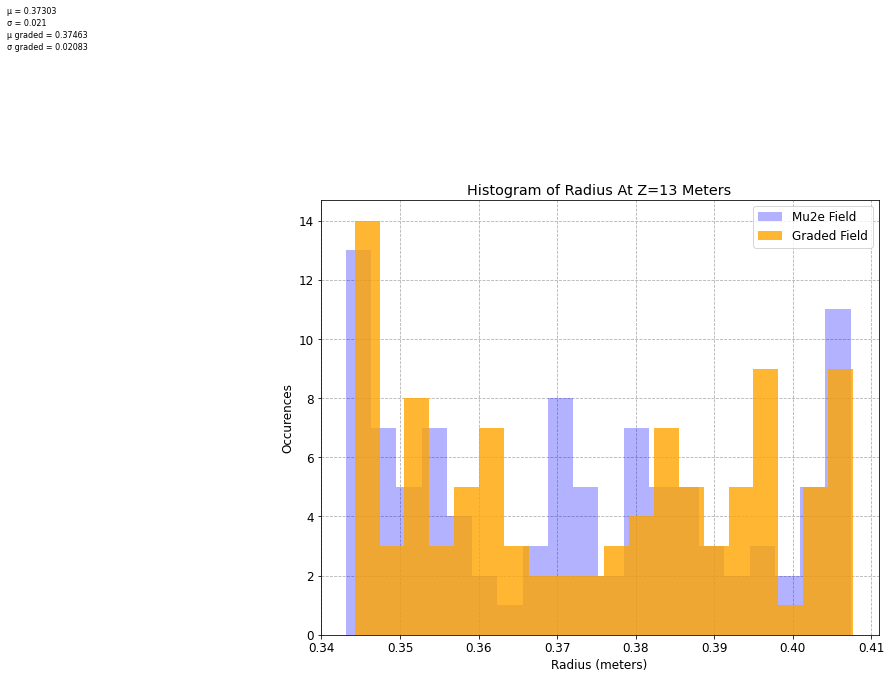

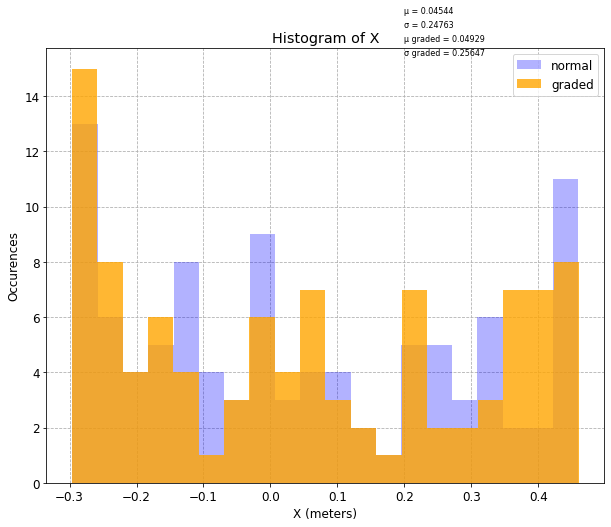

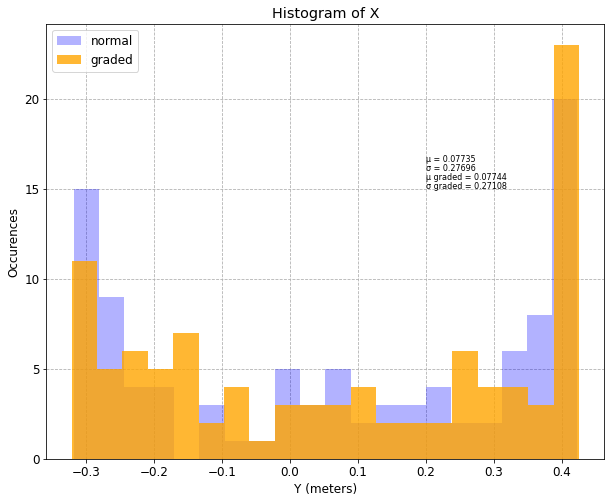

In [19]:
plotjoint(x, y, "run2")

<bound method Figure.show of <Figure size 720x576 with 1 Axes>>

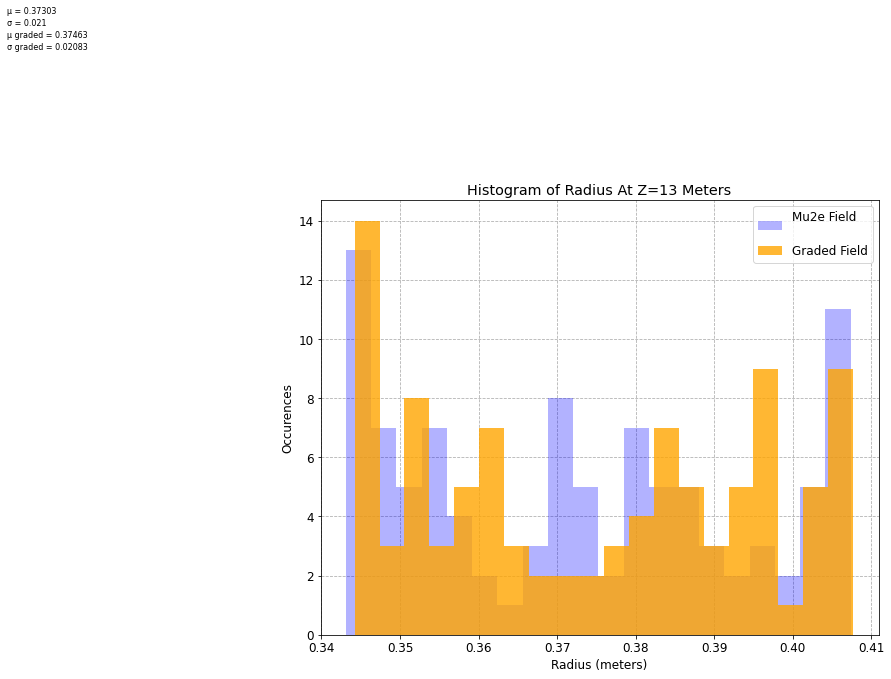

In [20]:
#x is regular, y is graded
x1, x2 = x[2], y[2]
num_bins = 20

m1 = np.mean(x1)
std1 = np.std(x1)
m2 = np.mean(x2)
std2 = np.std(x2)

fig = plt.figure()

plt.hist(x1, alpha = 0.3, bins = num_bins, facecolor='blue', label = 'Mu2e Field \n ')
plt.hist(x2, alpha = 0.8, bins = num_bins, facecolor='orange', label = 'Graded Field')

plt.legend()
plt.legend()

plt.text(0.3, 21, '\u03BC = '+str(round(np.mean(x1), 5)), fontsize = 8)
plt.text(0.3, 20.6, '\u03C3 = '+str(round(np.std(x1), 5)), fontsize = 8)
plt.text(0.3, 20.2, '\u03BC graded = '+str(round(np.mean(x2), 5)), fontsize = 8)
plt.text(0.3, 19.8, '\u03C3 graded = '+str(round(np.std(x2), 5)), fontsize = 8)

plt.xlabel('Radius (meters)')
plt.ylabel('Occurences')
plt.title('Histogram of Radius At Z=13 Meters')  
fig.show

<bound method Figure.show of <Figure size 720x576 with 1 Axes>>

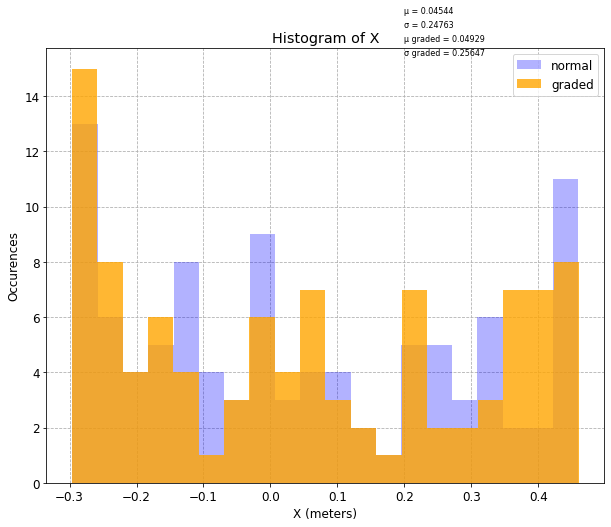

In [21]:
#x is regular, y is graded
x1, x2 = x[3], y[3]
num_bins = 20
m1 = np.mean(x1)
std1 = np.std(x1)
m2 = np.mean(x2)
std2 = np.std(x2)

fig = plt.figure()

plt.hist(x1, alpha = 0.3, bins = num_bins, facecolor='blue',  label = 'normal')
plt.hist(x2, alpha = 0.8, bins = num_bins, facecolor='orange',  label = 'graded')

plt.legend()


plt.text(0.2, 17, '\u03BC = '+str(round(np.mean(x1), 5)), fontsize = 8)
plt.text(0.2, 16.5, '\u03C3 = '+str(round(np.std(x1), 5)), fontsize = 8)
plt.text(0.2, 16, '\u03BC graded = '+str(round(np.mean(x2), 5)), fontsize = 8)
plt.text(0.2, 15.5, '\u03C3 graded = '+str(round(np.std(x2), 5)), fontsize = 8)

plt.xlabel('X (meters)')
plt.ylabel('Occurences')
plt.title('Histogram of X')  
fig.show

<bound method Figure.show of <Figure size 720x576 with 1 Axes>>

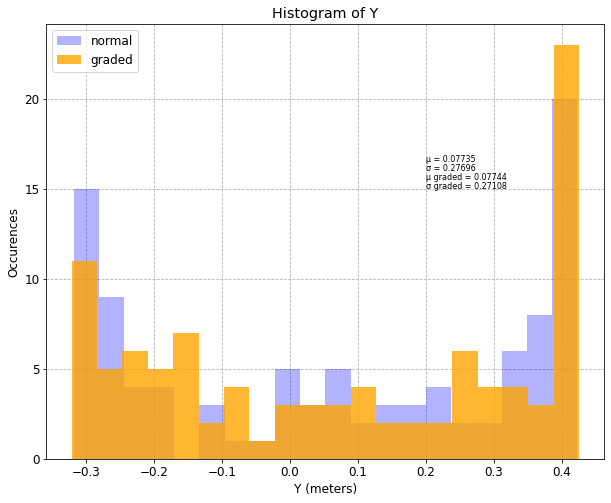

In [22]:
#x is regular, y is graded
x1, x2 = x[4], y[4]
num_bins = 20
m1 = np.mean(x1)
std1 = np.std(x1)
m2 = np.mean(x2)
std2 = np.std(x2)

fig = plt.figure()

plt.hist(x1, alpha = 0.3, bins = num_bins, facecolor='blue',  label = 'normal')
plt.hist(x2, alpha = 0.8, bins = num_bins, facecolor='orange',  label = 'graded')

plt.legend()

plt.text(0.2, 16.5, '\u03BC = '+str(round(np.mean(x1), 5)), fontsize = 8)
plt.text(0.2, 16, '\u03C3 = '+str(round(np.std(x1), 5)), fontsize = 8)
plt.text(0.2, 15.5, '\u03BC graded = '+str(round(np.mean(x2), 5)), fontsize = 8)
plt.text(0.2, 15, '\u03C3 graded = '+str(round(np.std(x2), 5)), fontsize = 8)

plt.xlabel('Y (meters)')
plt.ylabel('Occurences')
plt.title('Histogram of Y')  
fig.show